# Word usage by multiple artists

It obtains all lyrics for a given set of artists (parses HTML from www.metrolyrics.com) and returns a comparision of the words used by the artists.
Packages required: requests | re | time |

In [1]:
import sys
sys.path.insert(0, '../src')
from lyricsFunctions import *

In [2]:
listOfArtists = ['Eddie Vedder', 'Dire Straits']
songs4Artists = getSongs4Artists(listOfArtists)


http://www.metrolyrics.com/eddie-vedder-lyrics.html
eddie-vedder songs: ['society', 'hard sun', 'guaranteed', 'rise', 'society', 'hard sun', 'guaranteed', 'rise', 'tonight you belong to me', 'skipping', 'the long road', 'golden state', 'without you', 'all the way', 'better days', 'long nights', 'no ceiling', 'more than you know', 'all along the watchtower', 'goodbye', 'the long run', 'far behind', 'setting forth', 'longing to belong', 'broken heart', 'cant keep', 'waving palms', 'youre true', 'dream a little dream', 'sleeping by myself', 'go all the way', 'no more', 'sleepless nights', 'youve got to hide your love away', 'satellite', 'hey fahkah', 'golden stat', 'my city of ruins', 'once in awhile', 'light today', 'end of the road', 'imagine']

http://www.metrolyrics.com/dire-straits-lyrics.html
dire-straits songs: ['money for nothing', 'sultans of swing', 'romeo and juliet', 'brothers in arms', 'money for nothing', 'sultans of swing', 'romeo and juliet', 'brothers in arms', 'walk of 

For each artist, collect all words across all song lyrics:

In [3]:
lyrics4Artists = getLyrics4Artists(songs4Artists)

http://www.metrolyrics.com/society-lyrics-eddie-vedder.html
http://www.metrolyrics.com/hard-sun-lyrics-eddie-vedder.html
http://www.metrolyrics.com/money-for-nothing-lyrics-dire-straits.html
http://www.metrolyrics.com/sultans-of-swing-lyrics-dire-straits.html


Word extraction from artists lyrics and model generation:

In [5]:
m, cv, tf = buildNaiveBayesModel(lyrics4Artists) #use spacy for lemmatization and token

What is the probability of each of the artist to write the following songs?

In [7]:
test_songs = [
      "hello you yeah crocodile",
      "love you money yeah yeah yeah",
      "bennie and the candle",
      "with a little help from my crocodile"]

prediction, classProb, logProb = proba_Lyrics4Artists(test_songs, m, cv, tf)
prediction, classProb, logProb = proba_Lyrics4Artists(test_songs, m, cv, tf)



 Test songs might belong to:
['eddie-vedder' 'dire-straits' 'dire-straits' 'dire-straits']

 Each song probability from being from each artist:
[[0.48289099 0.51710901]
 [0.50975858 0.49024142]
 [0.59163508 0.40836492]
 [0.50760026 0.49239974]]
[[-5.78964283 -5.83057049 -5.78964283 -5.83057049 -5.83057049 -5.78964283
  -5.6478034  -5.79575431 -5.76677488 -5.75032459 -5.83057049 -5.83057049
  -5.79816403 -5.60608939 -5.83057049 -5.78964283 -5.78964283 -5.75032459
  -5.78964283 -5.78964283 -5.76114354 -5.83057049 -5.83057049 -5.78964283
  -5.75032459 -5.79575431 -5.83057049 -5.83057049 -5.83057049 -5.83057049
  -5.78964283 -5.83057049 -5.78964283 -5.83057049 -5.83057049 -5.83057049
  -5.83057049 -5.76210962 -5.75032459 -5.79575431 -5.83057049 -5.78964283
  -5.83057049 -5.78964283 -5.79575431 -5.83057049 -5.73634109 -5.83057049
  -5.78964283 -5.79575431 -5.76677488 -5.83057049 -5.78964283 -5.69803683
  -5.79575431 -5.78964283 -5.83057049 -5.72956015 -5.83057049 -5.83057049
  -5.79816403 

In [15]:
print(cv.vocabulary_)

{'oh': 203, 'it': 148, 'mystery': 194, 'to': 285, 'me': 180, 'we': 305, 'have': 128, 'greed': 119, 'with': 311, 'which': 310, 'agreed': 4, 'and': 13, 'you': 321, 'think': 277, 'want': 302, 'more': 189, 'than': 267, 'need': 195, 'until': 299, 'all': 8, 'won': 313, 'be': 26, 'free': 105, 'society': 248, 're': 224, 'crazy': 64, 'breed': 42, 'hope': 137, 'not': 199, 'lonely': 170, 'without': 312, 'when': 309, 'your': 323, 'thoughts': 280, 'begin': 29, 'bleed': 36, 'find': 99, 'bigger': 35, 'place': 216, 'because': 28, 'space': 253, 'indeed': 143, 'there': 273, 'those': 279, 'thinking': 278, 'or': 209, 'less': 164, 'is': 147, 'but': 46, 'if': 141, 'how': 140, 'keeping': 154, 'score': 238, 'means': 181, 'for': 102, 'every': 92, 'point': 221, 'make': 174, 'level': 165, 'drops': 85, 'kinda': 155, 'like': 167, 'starting': 255, 'from': 107, 'the': 269, 'top': 289, 'can': 50, 'do': 77, 'that': 268, 'mercy': 183, 'on': 205, 'angry': 14, 'disagree': 75, 'walk': 301, 'beside': 31, 'her': 132, 'am': 

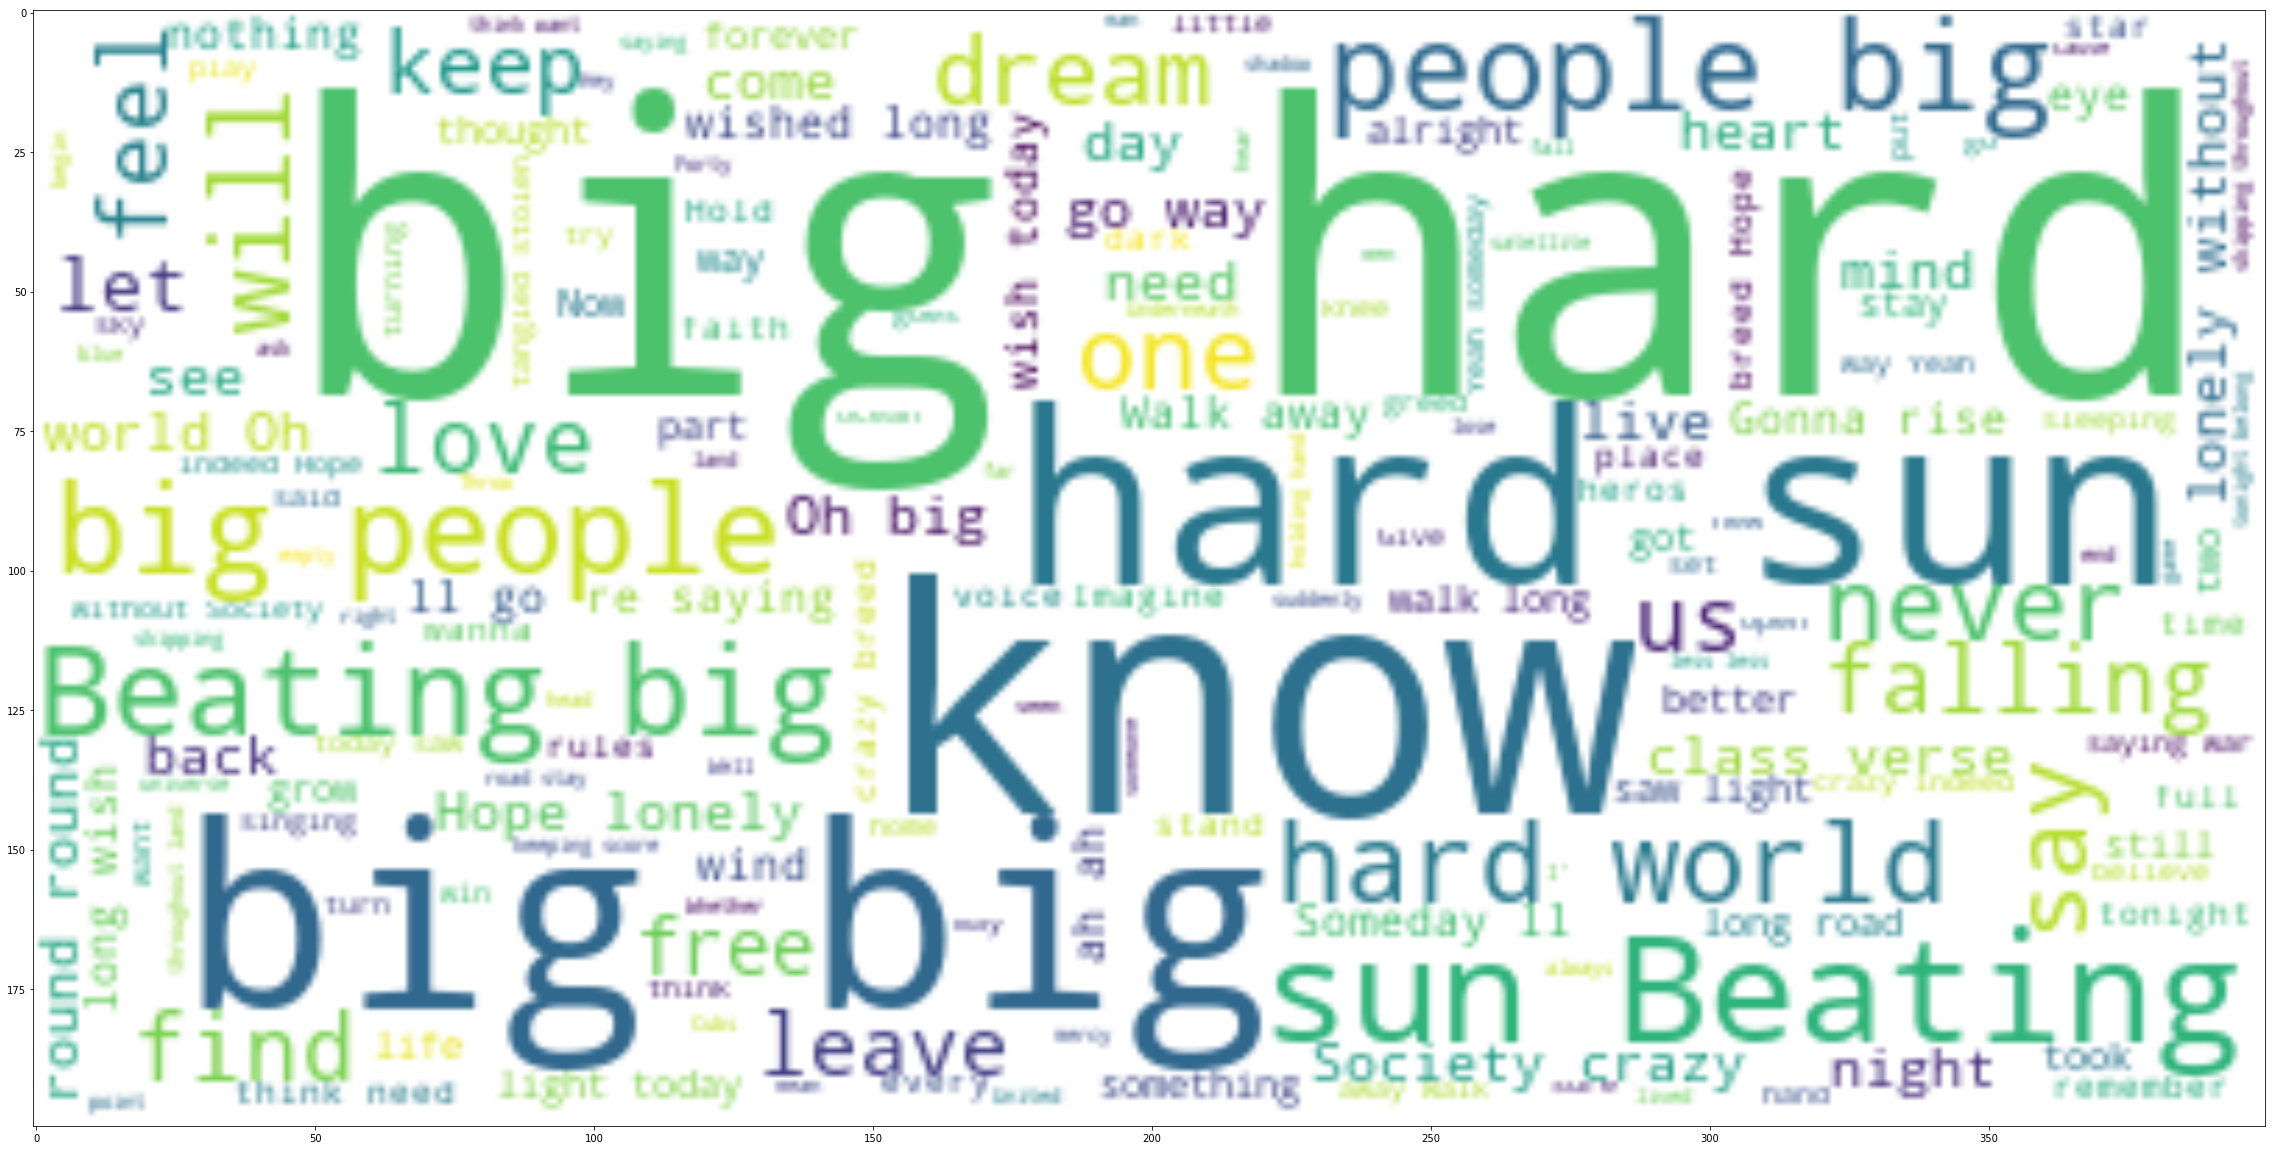

In [57]:
# look out for the wordcloud python package
import wordcloud
import matplotlib.pyplot as plt
wordcloud = wordcloud.WordCloud(background_color="white", max_words=2000, contour_color='steelblue').generate(allWords)

plt.figure(num = None, figsize = (40,40))
plt.imshow(wordcloud, interpolation='bilinear')